Import Library

In [10]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.graph_objs as go
plt.style.use('ggplot')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from lightgbm.sklearn import LGBMClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, RocCurveDisplay

import warnings
warnings.filterwarnings('ignore')

Mount G-Drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Import Data

In [4]:
fraud = pd.read_csv('/content/gdrive/MyDrive/fraud data/PS_20174392719_1491204439457_log.csv')

Reading Data and Viewing Column Data

In [5]:
fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


View data types and data amounts

In [6]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
fraud.shape

(6362620, 11)

Data Insights :

The dataset consist of 11 columns.
We have 5 columns of float datatype, 3 columns of integer datatype, and 3 columns of object datatype.

The dataset contains 6362620 rows of data.

check for duplicate data and null values

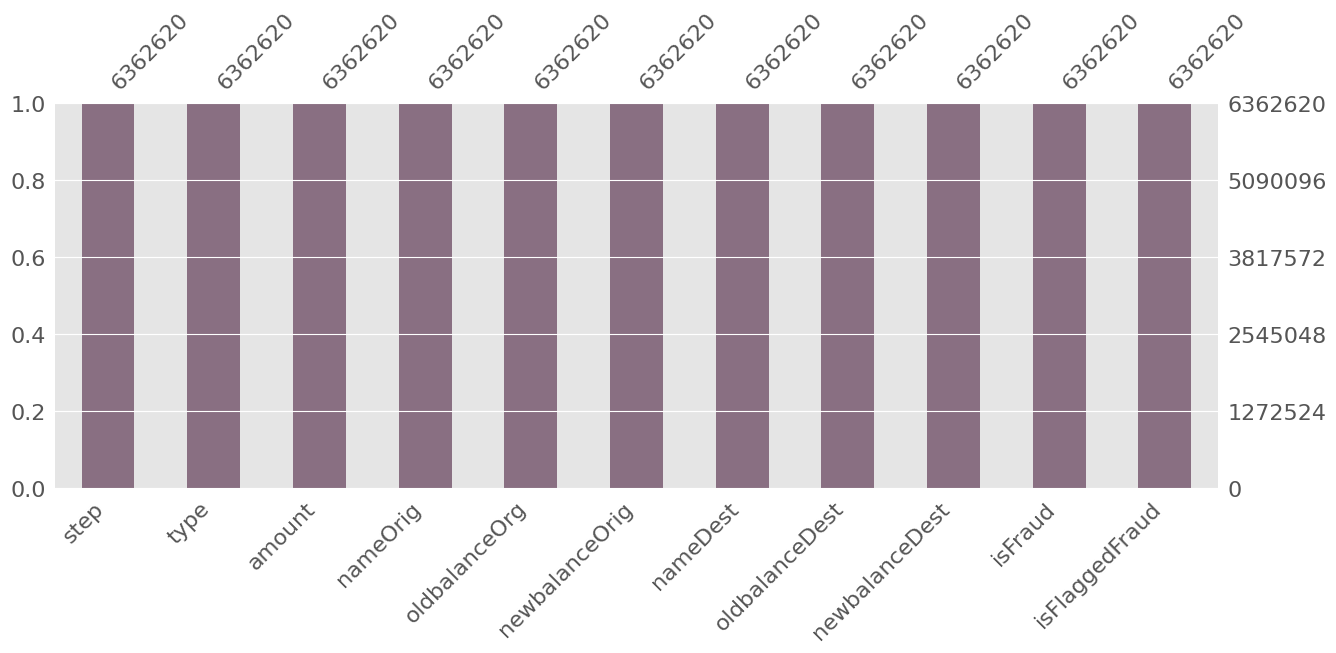

In [8]:
plt.figure(figsize = (15, 8))
msno.bar(fraud, figsize = (15,5), sort = 'ascending', color = "#896F82")
plt.show()

see the amount of duplicate data in the dataset.

In [9]:
print('Amount of duplicate data : ', fraud.duplicated().sum())

Amount of duplicate data :  0


Rename column

In [11]:
fraud = fraud.rename(columns = {'nameOrig' : 'origin', 'oldbalanceOrg' : 'sender_old_balance', 'newbalanceOrig': 'sender_new_balance', 'nameDest' : 'destination', 'oldbalanceDest' : 'receiver_old_balance', 'newbalanceDest': 'receiver_new_balance', 'isFraud' : 'isfraud'})

Drop column

In [12]:
fraud = fraud.drop(columns = ['step', 'isFlaggedFraud'], axis = 'columns')

Tidy up the Column order

In [13]:
cols = fraud.columns.tolist()
new_position = 3

cols.insert(new_position, cols.pop(cols.index('destination')))
fraud = fraud[cols]

check the changes in the dataset using the head function again.

In [14]:
fraud.head()

,type,amount,origin,destination,sender_old_balance,sender_new_balance,receiver_old_balance,receiver_new_balance,isfraud
0,PAYMENT,9839.64,C1231006815,M1979787155,170136.0,160296.36,0.0,0.0,0
1,PAYMENT,1864.28,C1666544295,M2044282225,21249.0,19384.72,0.0,0.0,0
2,TRANSFER,181.00,C1305486145,C553264065,181.0,0.00,0.0,0.0,1
3,CASH_OUT,181.00,C840083671,C38997010,181.0,0.00,21182.0,0.0,1
4,PAYMENT,11668.14,C2048537720,M1230701703,41554.0,29885.86,0.0,0.0,0


At this stage, we can see that our dataset is clean.

Data Comparison

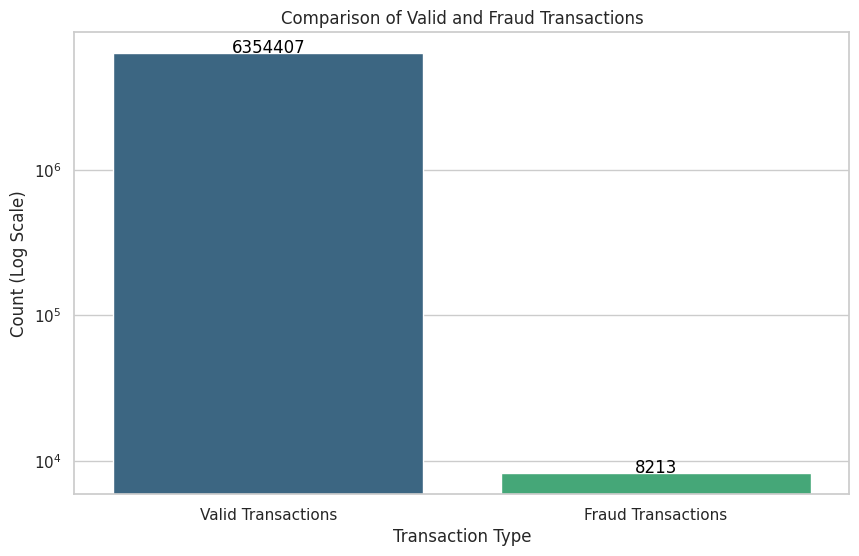

In [15]:
fraud_counts = fraud['isfraud'].value_counts().reset_index()
fraud_counts.columns=['isfraud','count']
fraud_counts['transaction_type'] = fraud_counts['isfraud'].map({0: 'Valid Transactions', 1: 'Fraud Transactions'})


sns.set(style="whitegrid")

# Create the bar plot with a logarithmic scale on the y-axis
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='transaction_type', y='count', data=fraud_counts, palette='viridis')
plt.yscale('log')
plt.title('Comparison of Valid and Fraud Transactions')
plt.xlabel('Transaction Type')
plt.ylabel('Count (Log Scale)')

# Add text labels above each bar
for index, row in fraud_counts.iterrows():
    ax.text(index, row['count'], str(row['count']), color='black', ha="center")

plt.show()

Searching for Fraud Data on transaction types

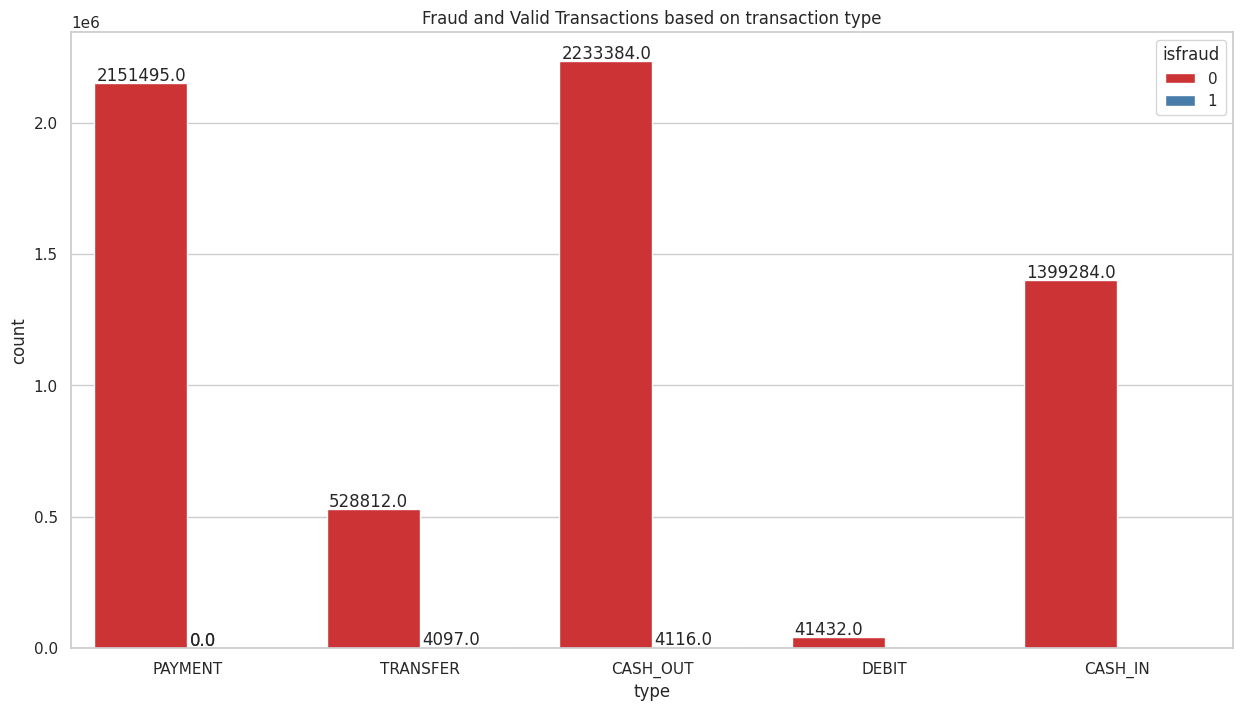

In [16]:
plt.figure(figsize = (15, 8))
ax=sns.countplot(data = fraud, x = "type", hue="isfraud", palette = 'Set1')
plt.title('Fraud and Valid Transactions based on transaction type')
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.01, p.get_height()+10000))

check the origin of transactions in the dataset

In [17]:
transfer_fraud = fraud[((fraud['type']=='TRANSFER') & fraud['isfraud']==1)]
transfer_fraud['origin'].value_counts()

,count
origin,
C1685995037,1
C369775274,1
C1524194171,1
C871130115,1
C1631161002,1
...,...
C1364127192,1
C669700766,1
C1872047468,1


check the destination of transactions in the dataset

In [18]:
cash_out_fraud = fraud[(fraud['type'] == 'CASH_OUT') & (fraud['isfraud'] == 1)]
cash_out_fraud['destination'].value_counts()

,count
destination,
C1650668671,2
C967226405,2
C2129197098,2
C964377943,2
C185805228,2
...,...
C1955464150,1
C1104137869,1
C377165949,1


check the account used for transfer and receive

In [20]:
fraud_trans = fraud[fraud['isfraud'] == 1]
valid_trans = fraud[fraud['isfraud'] == 0]

trans_transfer = fraud[fraud['type'] == 'TRANSER']
trans_cashout = fraud[fraud['type'] == 'CASH_OUT']

print('Is the account used for transferring and receiving the same?')
trans_transfer.destination.isin(trans_cashout.origin).any()

Is the account used for transferring and receiving the same?


False

As a result, important patterns have been discovered in the dataset.

1.   Fraudulent transactions are done by transfer and cash-out.
2.   Fraudulent transfer transactions = 4097, where the number of cash-out = 4116.
3.  Fraudulent transactions are mostly done from customer-to-customer.
4. The account used to transfer and receive funds is not the same in this situation.




Comparison between Valid and fraud transactions on cash out and transfer

In [21]:
fraud_filtered = fraud[fraud['type'].isin(['CASH_OUT', 'TRANSFER'])]

fraud_counts_filtered = fraud_filtered.groupby(['type', 'isfraud']).size().reset_index(name='count')

fraud_counts_filtered['transaction_type'] = fraud_counts_filtered['type'] + ' ' + fraud_counts_filtered['isfraud'].map({0: 'Valid', 1: 'Fraud'})


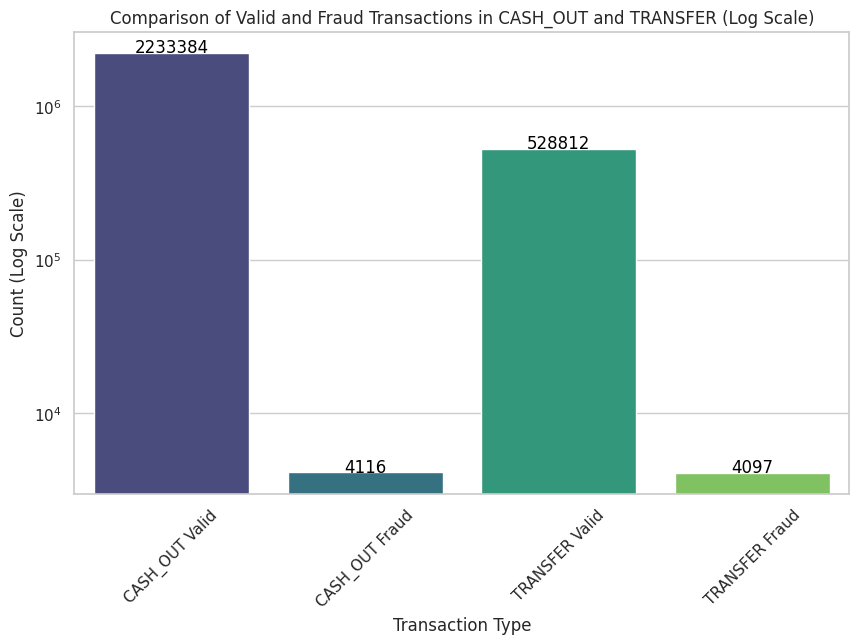

In [22]:
sns.set(style="whitegrid")

# Create the bar plot with a logarithmic scale on the y-axis
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='transaction_type', y='count', data=fraud_counts_filtered, palette='viridis')
plt.yscale('log')
plt.title('Comparison of Valid and Fraud Transactions in CASH_OUT and TRANSFER (Log Scale)')
plt.xlabel('Transaction Type')
plt.ylabel('Count (Log Scale)')
plt.xticks(rotation=45)

# Add text labels above each bar
for index, row in fraud_counts_filtered.iterrows():
    ax.text(index, row['count'], str(row['count']), color='black', ha="center")

plt.show()

Undersample

In [23]:
from sklearn.utils import resample

In [24]:
transfer_data = fraud_filtered[fraud_filtered['type'] == 'TRANSFER']
cash_out_data = fraud_filtered[fraud_filtered['type'] == 'CASH_OUT']

# Separate majority (valid transactions) and minority (fraud transactions) classes for each transaction type
valid_transfer = transfer_data[transfer_data['isfraud'] == 0]
fraud_transfer = transfer_data[transfer_data['isfraud'] == 1]

valid_cash_out = cash_out_data[cash_out_data['isfraud'] == 0]
fraud_cash_out = cash_out_data[cash_out_data['isfraud'] == 1]

# Undersample majority class (valid transactions) for each transaction type to match the number of fraud transactions
undersampled_valid_transfer = resample(valid_transfer,
                                       replace=False,
                                       n_samples=len(fraud_transfer),  # Equal to amount of Fraud Transactions
                                       random_state=42)

undersampled_valid_cash_out = resample(valid_cash_out,
                                       replace=False,
                                       n_samples=len(fraud_cash_out),  # Equal to amount of Fraud Transactions
                                       random_state=42)

# Combine minority class with undersampled majority class for each transaction type
undersampled_transfer_data = pd.concat([undersampled_valid_transfer, fraud_transfer])
undersampled_cash_out_data = pd.concat([undersampled_valid_cash_out, fraud_cash_out])

# Combine undersampled data for both transaction types
undersampled_data = pd.concat([undersampled_transfer_data, undersampled_cash_out_data])

undersampled_data = undersampled_data.sample(frac=1, random_state=42).reset_index(drop=True)

print(undersampled_data['isfraud'].value_counts())

isfraud
1    8213
0    8213
Name: count, dtype: int64


In [25]:
print(undersampled_data.columns)

Index(['type', 'amount', 'origin', 'destination', 'sender_old_balance',
       'sender_new_balance', 'receiver_old_balance', 'receiver_new_balance',
       'isfraud'],
      dtype='object')


Plot of undersampling results

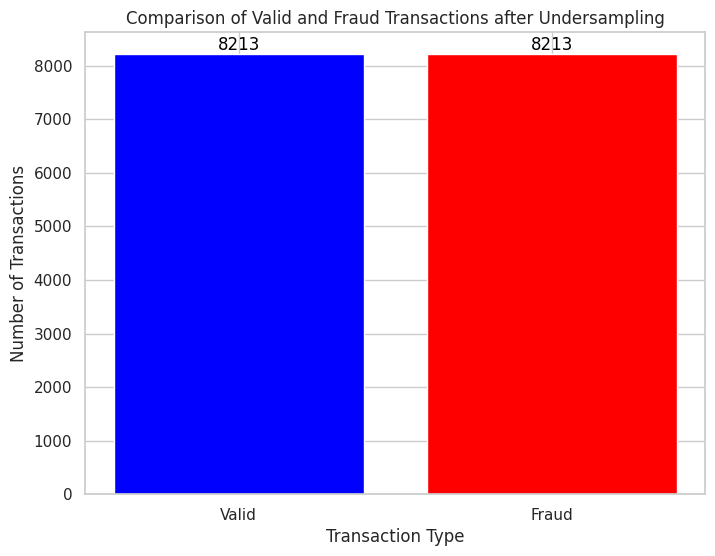

In [26]:
import matplotlib.pyplot as plt

# Calculate the number of valid and fraud transactions after undersampling
valid_count = undersampled_data[undersampled_data['isfraud'] == 0]['isfraud'].count()
fraud_count = undersampled_data[undersampled_data['isfraud'] == 1]['isfraud'].count()

plt.figure(figsize=(8, 6))

plt.bar(['Valid', 'Fraud'], [valid_count, fraud_count], color=['blue', 'red'])

for i, count in enumerate([valid_count, fraud_count]):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=12, color='black')

plt.title('Comparison of Valid and Fraud Transactions after Undersampling')
plt.xlabel('Transaction Type')
plt.ylabel('Number of Transactions')

plt.show()

check the number of fraud transactions based on the transaction type

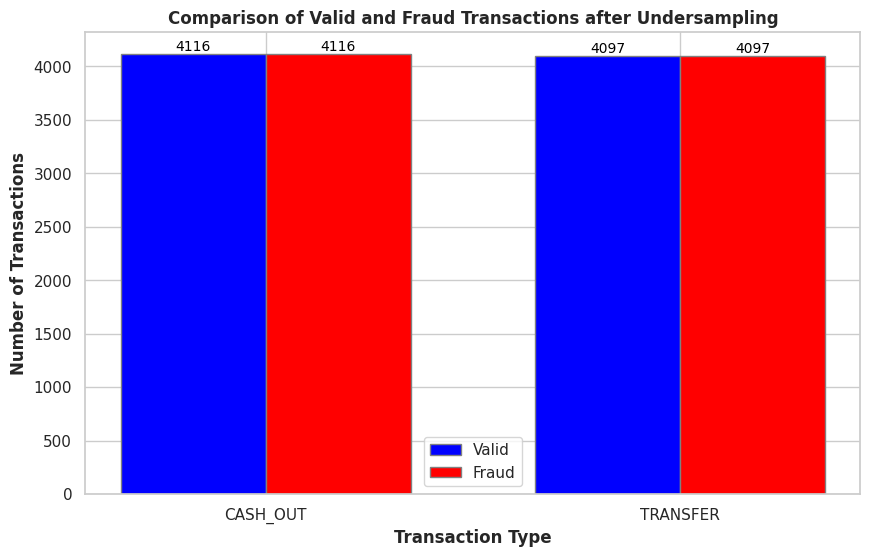

In [27]:
# Calculate the number of valid and fraud transactions after undersampling
valid_counts = undersampled_data[undersampled_data['isfraud'] == 0].groupby('type')['isfraud'].count()
fraud_counts = undersampled_data[undersampled_data['isfraud'] == 1].groupby('type')['isfraud'].count()

transaction_types = ['CASH_OUT', 'TRANSFER']

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35

r1 = np.arange(len(valid_counts))
r2 = [x + bar_width for x in r1]

ax.bar(r1, valid_counts, color='blue', width=bar_width, edgecolor='grey', label='Valid')
ax.bar(r2, fraud_counts, color='red', width=bar_width, edgecolor='grey', label='Fraud')

ax.set_xticks([r + bar_width / 2 for r in range(len(valid_counts))])
ax.set_xticklabels(transaction_types)

for i, count in enumerate(valid_counts):
    ax.text(i, count, str(count), ha='center', va='bottom', fontsize=10, color='black')
for i, count in enumerate(fraud_counts):
    ax.text(i + bar_width, count, str(count), ha='center', va='bottom', fontsize=10, color='black')

ax.set_xlabel('Transaction Type', fontweight='bold')
ax.set_ylabel('Number of Transactions', fontweight='bold')
ax.set_title('Comparison of Valid and Fraud Transactions after Undersampling', fontweight='bold')

ax.legend()

plt.show()

view transaction percentage based on type

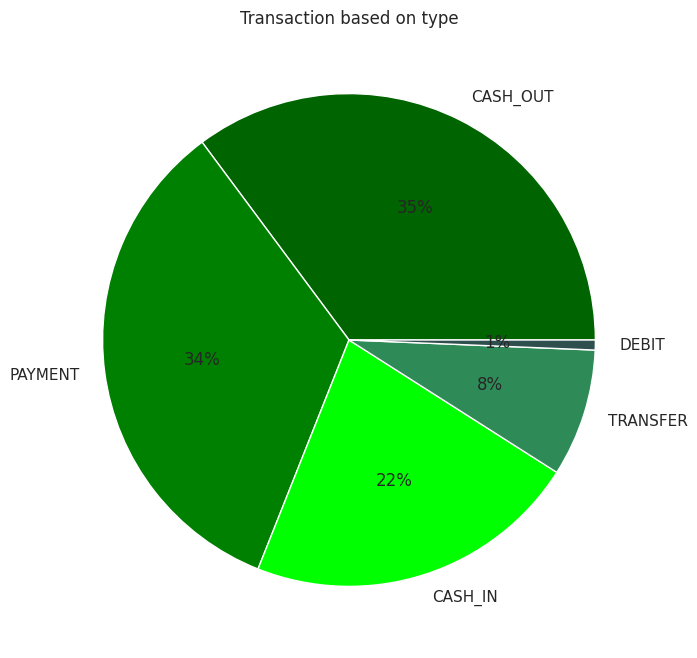

In [28]:
plt.figure(figsize=(15,8))
colors = ['#006400','#008000','#00FF00','#2E8B57','#2F4F4F']
plt.pie(fraud.type.value_counts().values,labels=fraud.type.value_counts().index, colors = colors, autopct='%.0f%%')
plt.title("Transaction based on type")
plt.show()

the dataset is divided into two sets,
named training and testing sets. 70% of the data
is used for training, and 30% is used for testing.

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


X = undersampled_data.drop('isfraud', axis=1)
y = undersampled_data['isfraud']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [30]:
# Define classifiers
rfc = RandomForestClassifier(n_estimators=15, n_jobs=-1, random_state=42)
lgbm = LGBMClassifier(boosting_type='gbdt', objective='binary', random_state=8888)
xgbr = xgb.XGBClassifier(max_depth=3, n_jobs=-1, random_state=42, learning_rate=0.1)
logreg = LogisticRegression(solver='liblinear', random_state=42)

# Create pipelines with preprocessing and model
rfc_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', rfc)])
lgbm_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', lgbm)])
xgbr_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', xgbr)])
logreg_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', logreg)])

# Train classifiers
rfc_pipeline.fit(X_train, y_train)
lgbm_pipeline.fit(X_train, y_train)
xgbr_pipeline.fit(X_train, y_train)
logreg_pipeline.fit(X_train, y_train)

# Store classifiers in a list
classifiers = [rfc_pipeline, lgbm_pipeline, xgbr_pipeline, logreg_pipeline]

[LightGBM] [Info] Number of positive: 5749, number of negative: 5749
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1279
[LightGBM] [Info] Number of data points in the train set: 11498, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


* n_estimators=15: This parameter determines the number of decision trees to be used in the random forest.
n_jobs=-1: Sets the number of jobs to be used to perform parallel computations. A value of -1 means using all available processors.
random_state=42: random number generator. This is used to ensure consistent and reproducible results.

* boosting_type='gbdt': Gradient Boosting Decision Trees (GBDT).
objective='binary': Determines the type of problem to be solved, namely binary classification.
random_state=8888: random number generator, to ensure consistent and reproducible results.

* max_depth=3: Specifies the maximum depth of each decision tree
n_jobs=-1: Specifies the number of jobs to be used to perform parallel computations. A value of -1 means using all available processors.
random_state=42: random number generator, to ensure consistent and reproducible results.
learning_rate=0.1: Specifies the step size when updating weights. Lower values ​​make the model learn slower and more thoroughly.

* solver='liblinear': Specifies the algorithm to be used for optimization. 'liblinear' is an efficient solver for small to medium datasets, especially for binary classification problems.
random_state=42: random number generator, to ensure consistent and reproducible results.

--------------------------------------------------------------------------------

Creating the model for the NON-UNDERSAMPLED DATASET

In [31]:
X_non_undersampled = fraud_filtered.drop('isfraud', axis=1)
y_non_undersampled = fraud_filtered['isfraud']

X_non_undersampled_train, X_non_undersampled_test, y_non_undersampled_train, y_non_undersampled_test = train_test_split(
    X_non_undersampled, y_non_undersampled, test_size=0.30, stratify=y_non_undersampled, random_state=42
)

In [32]:
# Define preprocessing steps for numerical and categorical columns
numeric_features = X_non_undersampled.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_non_undersampled.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=15, n_jobs=-1, random_state=42),
    'LightGBM': LGBMClassifier(boosting_type='gbdt', objective='binary', random_state=8888),
    'XGBoost': xgb.XGBClassifier(max_depth=3, n_jobs=-1, random_state=42, learning_rate=0.1),
    'Logistic Regression': LogisticRegression(solver='liblinear', random_state=42)
}

# Create pipelines
pipelines_non_undersampled = {name: Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
                              for name, model in classifiers.items()}

In [33]:
for name, pipeline in pipelines_non_undersampled.items():
    pipeline.fit(X_non_undersampled_train, y_non_undersampled_train)
    pipelines_non_undersampled[name] = pipeline

[LightGBM] [Info] Number of positive: 5749, number of negative: 1933537
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.458489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78507
[LightGBM] [Info] Number of data points in the train set: 1939286, number of used features: 38621
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002964 -> initscore=-5.818080
[LightGBM] [Info] Start training from score -5.818080


Perform predictions to determine the accuracy between these models and find the AUC for each model

In [42]:
accuracy_list = []
auc_list = []

for pipeline in classifiers:
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:,1]
    accuracy_list.append(accuracy_score(y_test, y_pred))
    auc_list.append(roc_auc_score(y_test, y_pred_proba))

accuracy_dict = {}
auc_dict = {}
for i in range(4):
    key=['Random Forest', 'Light GBM', 'XGBoost','LR'][i]
    accuracy_dict[key] = accuracy_list[i]
    auc_dict[key] = auc_list[i]

accuracy_dict_sorted = dict(sorted(accuracy_dict.items(), key = lambda item: item[1]))
auc_dict_sorted = dict(sorted(auc_dict.items(), key = lambda item: item[1]))


def px_bar(x,y,text,title,color,color_discrete_sequence):
    return px.bar(x = x, y = y, text = text, title = title, color = color, color_discrete_sequence=color_discrete_sequence, template='plotly_white')


fig = px_bar(list(auc_dict_sorted.keys()), list(auc_dict_sorted.values()), np.round(list(auc_dict_sorted.values()),3), 'AUC Scores for each model', list(auc_dict_sorted.keys()), px.colors.qualitative.Plotly)

fig.show()


Evaluation metrics for Random Forest on non-undersampled dataset:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828659
           1       0.99      0.69      0.81      2464

    accuracy                           1.00    831123
   macro avg       0.99      0.85      0.91    831123
weighted avg       1.00      1.00      1.00    831123

Confusion matrix for Random Forest on non-undersampled dataset:
[[828640     19]
 [   763   1701]]
----------------------------------------------------------


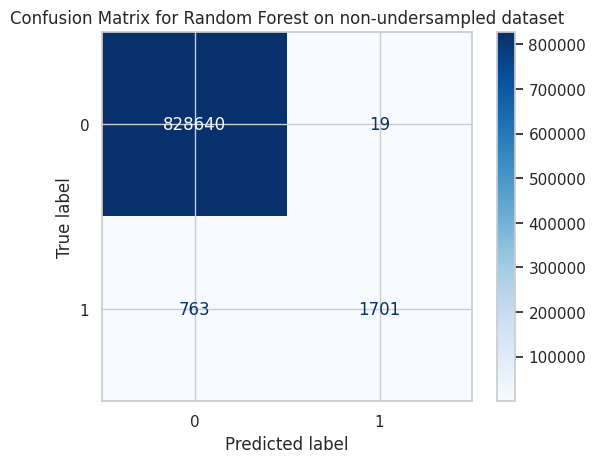

Evaluation metrics for LightGBM on non-undersampled dataset:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828659
           1       0.36      0.54      0.43      2464

    accuracy                           1.00    831123
   macro avg       0.68      0.77      0.71    831123
weighted avg       1.00      1.00      1.00    831123

Confusion matrix for LightGBM on non-undersampled dataset:
[[826266   2393]
 [  1144   1320]]
----------------------------------------------------------


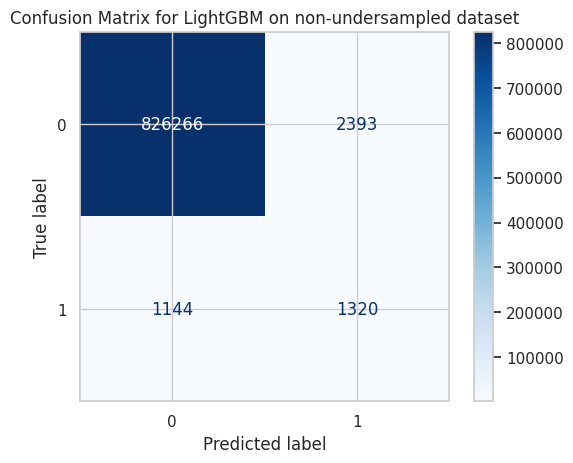

Evaluation metrics for XGBoost on non-undersampled dataset:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828659
           1       0.97      0.73      0.83      2464

    accuracy                           1.00    831123
   macro avg       0.99      0.86      0.92    831123
weighted avg       1.00      1.00      1.00    831123

Confusion matrix for XGBoost on non-undersampled dataset:
[[828613     46]
 [   674   1790]]
----------------------------------------------------------


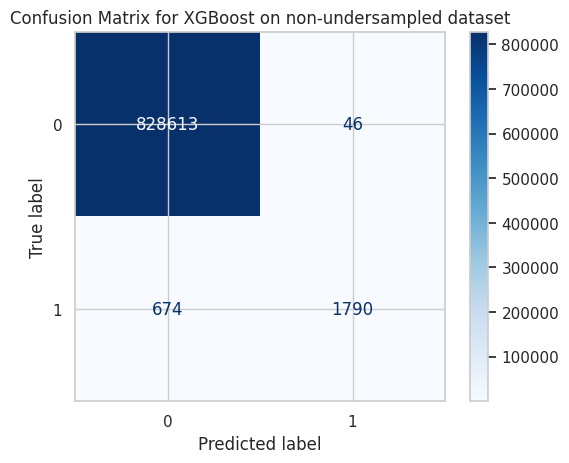

Evaluation metrics for Logistic Regression on non-undersampled dataset:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828659
           1       0.89      0.44      0.59      2464

    accuracy                           1.00    831123
   macro avg       0.95      0.72      0.80    831123
weighted avg       1.00      1.00      1.00    831123

Confusion matrix for Logistic Regression on non-undersampled dataset:
[[828529    130]
 [  1369   1095]]
----------------------------------------------------------


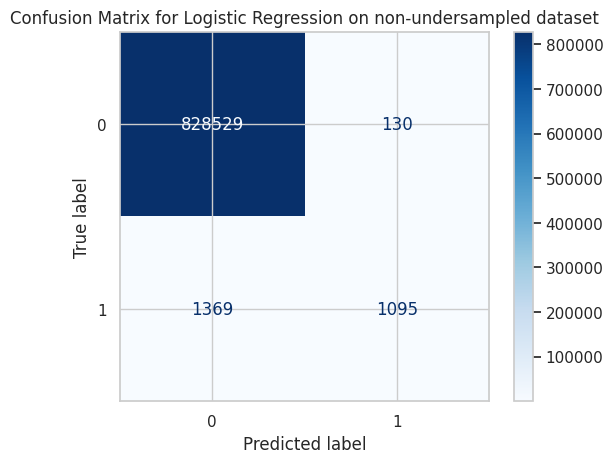

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_models(models, X_test, y_test, dataset_label):
    for name, model in models.items():
        y_pred = model.predict(X_test)

        # Print classification report
        print(f'Evaluation metrics for {name} on {dataset_label} dataset:')
        print(classification_report(y_test, y_pred))

        # Compute confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Print confusion matrix
        print(f'Confusion matrix for {name} on {dataset_label} dataset:')
        print(cm)
        print('----------------------------------------------------------')

        # Display confusion matrix using matplotlib
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for {name} on {dataset_label} dataset')
        plt.show()

# Evaluate on non-undersampled dataset
evaluate_models(pipelines_non_undersampled, X_non_undersampled_test, y_non_undersampled_test, "non-undersampled")

Consusion Matrix for Undersampled Data

Evaluation metrics for Random Forest on undersampled dataset:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2464
           1       0.98      0.96      0.97      2464

    accuracy                           0.97      4928
   macro avg       0.97      0.97      0.97      4928
weighted avg       0.97      0.97      0.97      4928

Confusion matrix for Random Forest on undersampled dataset:
[[2409   55]
 [ 101 2363]]
----------------------------------------------------------


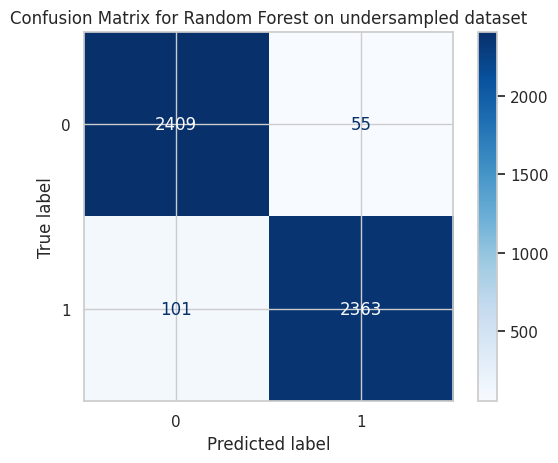

Evaluation metrics for Light GBM on undersampled dataset:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2464
           1       0.99      0.99      0.99      2464

    accuracy                           0.99      4928
   macro avg       0.99      0.99      0.99      4928
weighted avg       0.99      0.99      0.99      4928

Confusion matrix for Light GBM on undersampled dataset:
[[2448   16]
 [  14 2450]]
----------------------------------------------------------


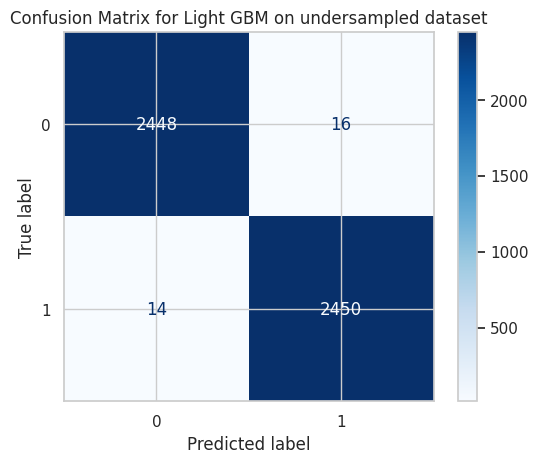

Evaluation metrics for XGBoost on undersampled dataset:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2464
           1       0.98      0.99      0.99      2464

    accuracy                           0.99      4928
   macro avg       0.99      0.99      0.99      4928
weighted avg       0.99      0.99      0.99      4928

Confusion matrix for XGBoost on undersampled dataset:
[[2418   46]
 [  15 2449]]
----------------------------------------------------------


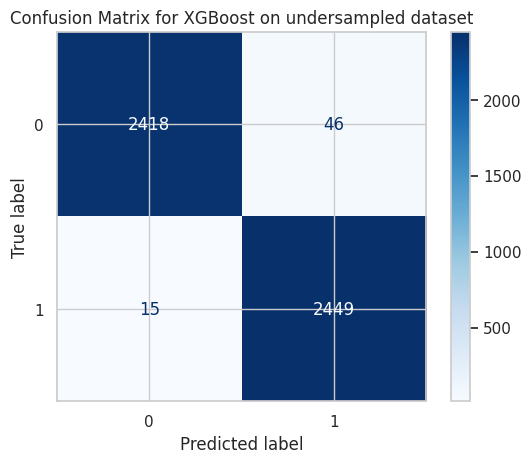

Evaluation metrics for Logistic Regression on undersampled dataset:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      2464
           1       0.94      0.83      0.88      2464

    accuracy                           0.89      4928
   macro avg       0.90      0.89      0.89      4928
weighted avg       0.90      0.89      0.89      4928

Confusion matrix for Logistic Regression on undersampled dataset:
[[2344  120]
 [ 414 2050]]
----------------------------------------------------------


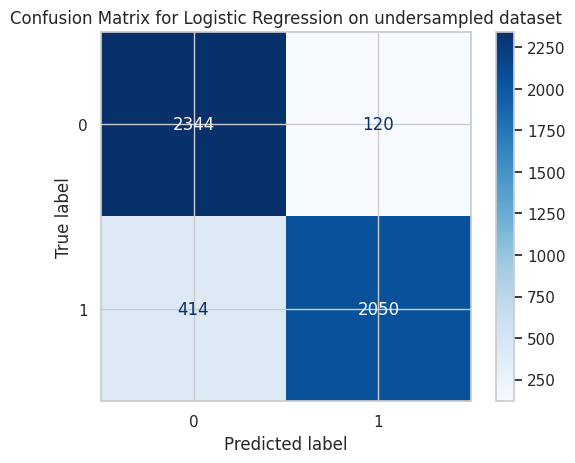

In [41]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define the list of classifiers and their corresponding labels
classifiers = [rfc_pipeline, lgbm_pipeline, xgbr_pipeline, logreg_pipeline]
labels = ['Random Forest', 'Light GBM', 'XGBoost', 'Logistic Regression']

# Function to evaluate models
def evaluate_models(models, labels, X_test, y_test, dataset_label):
    for model, label in zip(models, labels):
        y_pred = model.predict(X_test)

        # Print classification report
        print(f'Evaluation metrics for {label} on {dataset_label} dataset:')
        print(classification_report(y_test, y_pred))

        # Compute confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Print confusion matrix
        print(f'Confusion matrix for {label} on {dataset_label} dataset:')
        print(cm)
        print('----------------------------------------------------------')

        # Display confusion matrix using matplotlib
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for {label} on {dataset_label} dataset')
        plt.show()

# Evaluate on undersampled dataset
evaluate_models(classifiers, labels, X_test, y_test, "undersampled")